# Create COCO annotations from masks

Based on https://github.com/bnsreenu/python_for_microscopists/blob/master/332%20-%20All%20about%20image%20annotations%E2%80%8B/binary_to_coco_V3.0.py

YT video with explanation: https://www.youtube.com/watch?v=NYeJvxe5nYw

In [3]:
import glob
import json
import os
import cv2
import yaml
import shutil

In [11]:
MASK_EXT = 'tif'
ORIGINAL_EXT = 'tif'
MASK_PATH = 'labels'
IMG_PATH = 'images'

In [3]:
def create_annotation_for_contour(contour, annotation_id: int, image_id):
    bbox = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    segmentation = contour.flatten().tolist()

    annotation = {
        "iscrowd": 0,
        "id": annotation_id,
        "image_id": image_id,
        "category_id": 1,
        "bbox": bbox,
        "area": area,
        "segmentation": [segmentation],
    }

    return annotation

In [4]:
def contours_from_mask_image(mask_image_open):
    # Find contours in the mask image
    gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return contours

In [5]:
def images_annotations_info(path):
    """
    Process the binary masks and generate images and annotations information.

    :param path: Path to the directory containing images and binary masks
    :return: Tuple containing images info, annotations info, and annotation count
    """
    global image_id, annotation_id
    annotations = []
    images = []


    for mask_image in glob.glob(os.path.join(path, MASK_PATH, f'*.{MASK_EXT}')):
        original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
        mask_image_open = cv2.imread(mask_image)

        # Get image dimensions
        height, width, _ = mask_image_open.shape

        # Create or find existing image annotation
        if original_file_name not in map(lambda img: img['file_name'], images):
            image = {
                "id": image_id + 1,
                "width": width,
                "height": height,
                "file_name": original_file_name,
            }
            images.append(image)
            image_id += 1
        else:
            image = [element for element in images if element['file_name'] == original_file_name][0]

        contours = contours_from_mask_image(mask_image_open)

        # Create annotation for each contour
        for contour in contours:
            annotation = create_annotation_for_contour(contour, annotation_id, image['id'])

            # Add annotation if area is greater than zero
#             if annotation["area"] > 0:
            annotations.append(annotation)
            annotation_id += 1

    return images, annotations, annotation_id


In [6]:
def process_masks(mask_path, dest_json):
    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": 1, "name": 'Vessel', "supercategory": 'Vessel'}],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


In [7]:
global image_id, annotation_id
image_id = 0
annotation_id = 0

In [8]:
kidney1_dense_path = "/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"
kidney1_dense_json_path = "/kaggle/working/kidney1_dense_coco.json"
kidney3_sparse_path = "/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse"
kidney3_sparse_json_path = "/kaggle/working/kidney3_sparse_coco.json"

In [9]:
process_masks(kidney1_dense_path, kidney1_dense_json_path)
process_masks(kidney3_sparse_path, kidney3_sparse_json_path)

Created 224783 annotations for images in folder: /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense
Created 293990 annotations for images in folder: /kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse


In [30]:
!grep -C 2 '"image_id": 902' kidney1_dense_coco.json


In [9]:
!tail /kaggle/working/kidney3_sparse_coco.json

        {
            "file_name": "0795.tif",
            "height": 1706,
            "id": 3314,
            "width": 1510
        }
    ],
    "info": {},
    "licenses": []
}

In [5]:
!rm /kaggle/working/yolov8n.pt

## Create a small subset for experiments and visualizations

Create directory

In [20]:
!mkdir -p small_train/images
!mkdir -p small_train/labels

Copy images

In [17]:
! cp /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/04**.tif /kaggle/working/small_train/images/

Copy masks

In [21]:
! cp /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/04**.tif small_train/labels/

Create coco json for the small training subset

In [22]:
small_train_path = "small_train"
small_train_json_path = "small_train_coco.json"
process_masks(small_train_path, small_train_json_path)

Created 9251 annotations for images in folder: small_train


### Convert images to png and modify the annotations to be able to visualize them on roboflow

```shell
# from the folder where tif image files are
mkdir ../png
# convert tif files to png
sips -s format png *.tif --out ../png
cd ..
# copy coco annotation json
cp small_train_coco.json png
cd png
#replace the filenames in the annotation
sed -i '' 's/\.tif/\.png/g' small_train_coco.json
```

Now the `png` folder is ready to be uploaded and visualized with roboflow

https://app.roboflow.com/



# Convert COCO annotations to YOLO

Looks like for YOLO
> ALL images are used during training. If no labels are found then the image simply has no labels.

https://github.com/ultralytics/yolov5/discussions/7148

In [17]:
# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    with open(input_json_path) as f:
        coco_json = json.load(f)

    # Create directories for output labels
    os.makedirs(output_labels_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(f".{ORIGINAL_EXT}"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in coco_json['annotations'] if ann['image_id'] == image_id]

    # Function to get image coco_json
    def get_img(filename):
        return next((img for img in coco_json['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")


In [18]:
input_images_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images'
input_json_path = '/kaggle/working/kidney1_dense_coco.json'
output_labels_path = 'kidney1_dense_yolo/labels'
output_images_path = 'kidney1_dense_yolo/images'

In [19]:
val_input_images_path = '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images'
val_input_json_path = '/kaggle/working/kidney3_sparse_coco.json'
val_output_labels_path = 'kidney3_sparse_yolo/labels'
val_output_images_path = 'kidney3_sparse_yolo/images'

In [20]:
convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path)
convert_to_yolo(val_input_images_path, val_input_json_path, val_output_images_path, val_output_labels_path)

In [21]:
# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    
    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)

In [22]:
train_path = '/kaggle/working/kidney1_dense_yolo/images'
val_path = '/kaggle/working/kidney3_sparse_yolo/images'

In [23]:
create_yaml(input_json_path, 'kidney_1_dense.yaml', train_path=train_path, val_path=val_path)

In [24]:
!cat kidney_1_dense.yaml

names:
- Vessel
nc: 1
test: ''
train: /kaggle/working/kidney1_dense_yolo/images
val: /kaggle/working/kidney3_sparse_yolo/images


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    
    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10')

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()  # Display the image with annotations

/tmp/ipykernel_42/2620079538.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


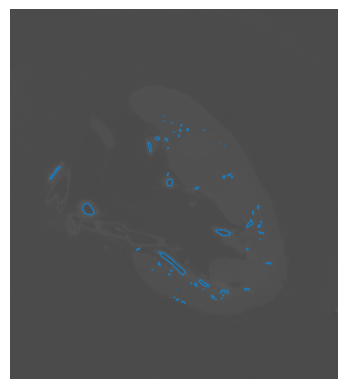

In [26]:
image_path = "/kaggle/working/kidney3_sparse_yolo/images/0312.tif"
annotation_path = "/kaggle/working/kidney3_sparse_yolo/labels/0312.txt"
display_image_with_annotations(image_path, annotation_path)

# Train YOLOv8 on the custom data

In [1]:
# Install the ultralytics package using pip
!pip install ultralytics==8.0.186
!pip install wandb
!pip install -U ipywidgets

  Obtaining dependency information for ultralytics==8.0.186 from https://files.pythonhosted.org/packages/ef/76/1031a2ae4da308cb01ff62361bf6489f2227ac4efb166c35961e4ded7502/ultralytics-8.0.186-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.4/618.4 kB 4.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import wandb 
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

from wandb.integration.ultralytics import add_wandb_callback

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



### Import a model and populate it with pre-trained weights.

In [4]:
#Instance
model = YOLO('yolov8n-seg.yaml')  # build a new model from YAML
model = YOLO('yolov8n-seg.pt')  # Transfer the weights from a pretrained model (recommended for training)
add_wandb_callback(model, enable_model_checkpointing=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_runnin

In [5]:
!cat /kaggle/working/kidney_1_dense.yaml

names:
- Vessel
nc: 1
test: ''
train: /kaggle/working/kidney1_dense_yolo/images
val: /kaggle/working/kidney3_sparse_yolo/images


## Train the model

In [6]:
project = 'hacking_human_vasculature'
name = 'kidney_1_dense_train_kidney_3_sparse_val'

In [ ]:
# Train the model
results = model.train(data='/kaggle/working/kidney_1_dense.yaml',
                      project=project,
                      name=name,
                      epochs=10,
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=4,
                      imgsz=800,
#                       device=[0, 1]
                     )

In [ ]:
# Finish the W&B run
wandb.finish()


In [10]:
from IPython.display import Image
